# Goal

In this competition, you are challenged to develop a model capable of predicting the closing price movements for hundreds of Nasdaq listed stocks using data from the order book and the closing auction of the stock. Information from the auction can be used to adjust prices, assess supply and demand dynamics, and identify trading opportunity.

Stock exchanges are fast-paced, high-stakes environments where every second counts. The intensity escalates as the trading day approaches its end, peaking in the critical final ten minutes. These moments, often characterised by heightened volatility and rapid price fluctuations, play a pivotal role in shaping the global economic narrative for the day.

Each trading day on the Nasdaq Stock Exchange concludes with the Nasdaq Closing Cross auction. This process establishes the official closing prices for securities listed on the exchange. These closing prices serve as key indicators for investors, analysts and other market participants in evaluating the performance of individual securities and the market as a whole.

Within this complex financial landscape operates Optiver, a leading global electronic market maker. Fueled by technological innovation, Optiver trades a vast array of financial instruments, such as derivatives, cash equities, ETFs, bonds, and foreign currencies, offering competitive, two-sided prices for thousands of these instruments on major exchanges worldwide.

In the last ten minutes of the Nasdaq exchange trading session, market makers like Optiver merge traditional order book data with auction book data. This ability to consolidate information from both sources is critical for providing the best prices to all market participants.

In this competition, you are challenged to develop a model capable of predicting the closing price movements for hundreds of Nasdaq listed stocks using data from the order book and the closing auction of the stock. Information from the auction can be used to adjust prices, assess supply and demand dynamics, and identify trading opportunities.

Your model can contribute to the consolidation of signals from the auction and order book, leading to improved market efficiency and accessibility, particularly during the intense final ten minutes of trading. You'll also get firsthand experience in handling real-world data science problems, similar to those faced by traders, quantitative researchers and engineers at Optiver.


# Description of the Files
- [train/test].csv - the auction data
- sample_submission - a valid sample submission
- revealed_targets - when the first time_id for each date (i.e. when seconds_in_bucket equals zero) the API will serve a dataframe providing the true target values for the entire previous date. All other rows contain null values for the columns of interest.
- public_timeseries_testing_util.py - an optional file intended to make it easier to run custom offline API tests. See the script's docstring for details. You will need to edit this file before using it.
- example_test_files/ - data intended to illustrate how the API functions. Includes the same files and columns delivered by the API. The first three date ids are repeats of the last three date ids in the train set, to enable an illustration of how the API functions.
- optiver2023/ - files that enable the API. Expect the API to deliver all rows in under five minutes and to reserve less than 0.5 GB of memory. The first three date ids delivered by the API are repeats of the last three date ids in the train set, to better illustrate how the API functions. You must make predictions for those dates in order to advance the API but those predictions are not scored.

# Target Metric
$$\text{MAE} = \dfrac{1}{n} \sum^n_{i=1} |y_i - x_i|,$$
where:
- $n$ is the total number of data points.
- $y_i$ is the predicted value for data point $i$.
- $x_i$ is the observed value for data point $i$.


# Imports

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython import display
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
# from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, ElasticNet
from  sklearn.linear_model import LinearRegression
from IPython.display import display

from sklearn.model_selection import TimeSeriesSplit
from catboost import Pool
from sklearn.metrics import mean_absolute_error


# Data Preprocessing and EDA

In [3]:
# read and print train dataframe
df = pd.read_csv('Optiver Trading Close/train.csv')
df = df.set_index('row_id')
test = pd.read_csv('Optiver Trading Close/example_test_files/test.csv')
test = test.set_index('row_id')
test_target = pd.read_csv('Optiver Trading Close/example_test_files/revealed_targets.csv')
print(f'Train shape: {df.shape}')
print(f'Test shape: {test.shape}')
df.sample(5)

Train shape: (5237980, 16)
Test shape: (33000, 16)


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
row_id,,,,,,,,,,,,,,,,
241_110_175,175,241,110,32800259.97,1,0.998940,2.120749e+08,NaN,NaN,0.998764,22690.00,0.999028,28370.00,0.998881,-2.430081,13266
398_420_161,161,398,420,103403.06,1,1.002814,2.672165e+06,1.010028,1.003535,1.002092,141900.24,1.002814,51763.60,1.002621,-0.489950,21932
376_500_115,115,376,500,0.00,0,1.001242,4.020842e+07,1.001242,1.001242,1.000918,95198.40,1.001242,24889.45,1.001175,-2.480149,20730
297_540_197,197,297,540,801938.56,-1,0.999755,1.375220e+07,0.999503,0.999503,0.999755,5328.51,1.000006,65787.85,0.999774,-6.809831,16389
374_430_171,171,374,430,553953.78,1,0.996733,1.253366e+07,0.998492,0.997436,0.996645,39662.00,0.996820,37968.90,0.996734,8.879900,20613


Columns:
- stock_id - A unique identifier for the stock. Not all stock IDs exist in every time bucket.
- date_id - A unique identifier for the date. Date IDs are sequential & consistent across all stocks.
- imbalance_size - The amount unmatched at the current reference price (in USD).
- imbalance_buy_sell_flag - An indicator reflecting the direction of auction imbalance.
- - buy-side imbalance = 1
- - sell-side imbalance = -1
- - no imbalance = 0
- reference_price - The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.
- matched_size - The amount that can be matched at the current reference price (in USD).
- far_price - The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.
- near_price - The crossing price that will maximize the number of shares matched based auction and continuous market orders.
- [bid/ask]_price - Price of the most competitive buy/sell level in the non-auction book.
- [bid/ask]_size - The dollar notional amount on the most competitive buy/sell level in the non-auction book.
- wap - The weighted average price in the non-auction book.
$$\text{WAP} = \dfrac{BidPrice \cdot AskSize + AskPrice \cdot BidPrice}{BidSize + AskSize}$$
- seconds_in_bucket - The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.
- target - The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index. Only provided for the train set.
- - The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition.
- - The unit of the target is basis points, which is a common unit of measurement in financial markets. A 1 basis point price move is equivalent to a 0.01% price move.
- - Where $t$ is the time at the current observation, we can define the target:

$$\text{Target} = \left( \dfrac{StockWAP_{t+60}}{StockWAP_t} - \dfrac{IndexWAP_{t+60}}{IndexWAP_t} \right) \cdot 10000$$

In [4]:
# get info about columns (analog of .describe() but with additional info)
def get_columns_info(df: pd.DataFrame) -> pd.DataFrame:
    info_df = pd.DataFrame({
        'Num Unique': df.nunique(),
        'Contain Null': df.isna().any(),
        'Num Null': df.isna().sum(),
        '% Null': round((df.isna().sum() / len(df)) * 100, 2),
        'dtype': df.dtypes
    })

    numeric_cols = df.select_dtypes(include=[np.number]).columns

    info_df['Mean'] = df[numeric_cols].mean()
    info_df['Mean'] = df[numeric_cols].std()
    info_df['Min'] = df[numeric_cols].min()
    info_df['1Q'] = df[numeric_cols].quantile(.25)
    info_df['Median'] = df[numeric_cols].median()
    info_df['3Q'] = df[numeric_cols].quantile(.75)
    info_df['Max'] = df[numeric_cols].max()

    non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns
    for col in ['Min', '1Q', 'Median', '3Q', 'Max']:
        info_df.loc[non_numeric_cols, col] = '-'

    return info_df

get_columns_info(df)

,Num Unique,Contain Null,Num Null,% Null,dtype,Mean,Min,1Q,Median,3Q,Max
stock_id,200,False,0,0.00,int64,5.787176e+01,0.000000,4.900000e+01,9.900000e+01,1.490000e+02,1.990000e+02
date_id,481,False,0,0.00,int64,1.385319e+02,0.000000,1.220000e+02,2.420000e+02,3.610000e+02,4.800000e+02
seconds_in_bucket,55,False,0,0.00,int64,1.587451e+02,0.000000,1.300000e+02,2.700000e+02,4.100000e+02,5.400000e+02
imbalance_size,2971863,True,220,0.00,float64,2.051591e+07,0.000000,8.453415e+04,1.113604e+06,4.190951e+06,2.982028e+09
imbalance_buy_sell_flag,3,False,0,0.00,int64,8.853374e-01,-1.000000,-1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
reference_price,28741,True,220,0.00,float64,2.532497e-03,0.935285,9.987630e-01,9.999670e-01,1.001174e+00,1.077488e+00
matched_size,2948862,True,220,0.00,float64,1.398413e+08,4316.610000,5.279575e+06,1.288264e+07,3.270013e+07,7.713682e+09
far_price,95739,True,2894342,55.26,float64,7.214705e-01,0.000077,9.963320e-01,9.998830e-01,1.003318e+00,4.379531e+02
near_price,84625,True,2857180,54.55,float64,1.216920e-02,0.786988,9.971000e-01,9.998890e-01,1.002590e+00,1.309732e+00
bid_price,28313,True,220,0.00,float64,2.499345e-03,0.934915,9.985290e-01,9.997280e-01,1.000905e+00,1.077488e+00


Here are some conclusion we can draw from this table:
- we have info about 200 stocks for 481 days. The time window for each day is 10 minutes and we have the info about price changes inside this window.
- for columns related to prices (`reference_price`, `far_price`, `near_price`, `bid_price`, `ask_price`) scaling is already applied, so we do not have to deal with the problem of difference in price values
- columns, related to size, should be scaled, because the difference between quartiles is high
- the structure of the dataset sets some restrictions on preprocessing because of the nature of the data, so we should be careful with it

In [5]:
COLOR = 'cornflowerblue'

numerical_cols = ['imbalance_size', 'reference_price', 'matched_size', 
                  'far_price', 'near_price', 'bid_price', 'ask_price', 
                  'bid_size', 'ask_size', 'wap', 'seconds_in_bucket', 'target']

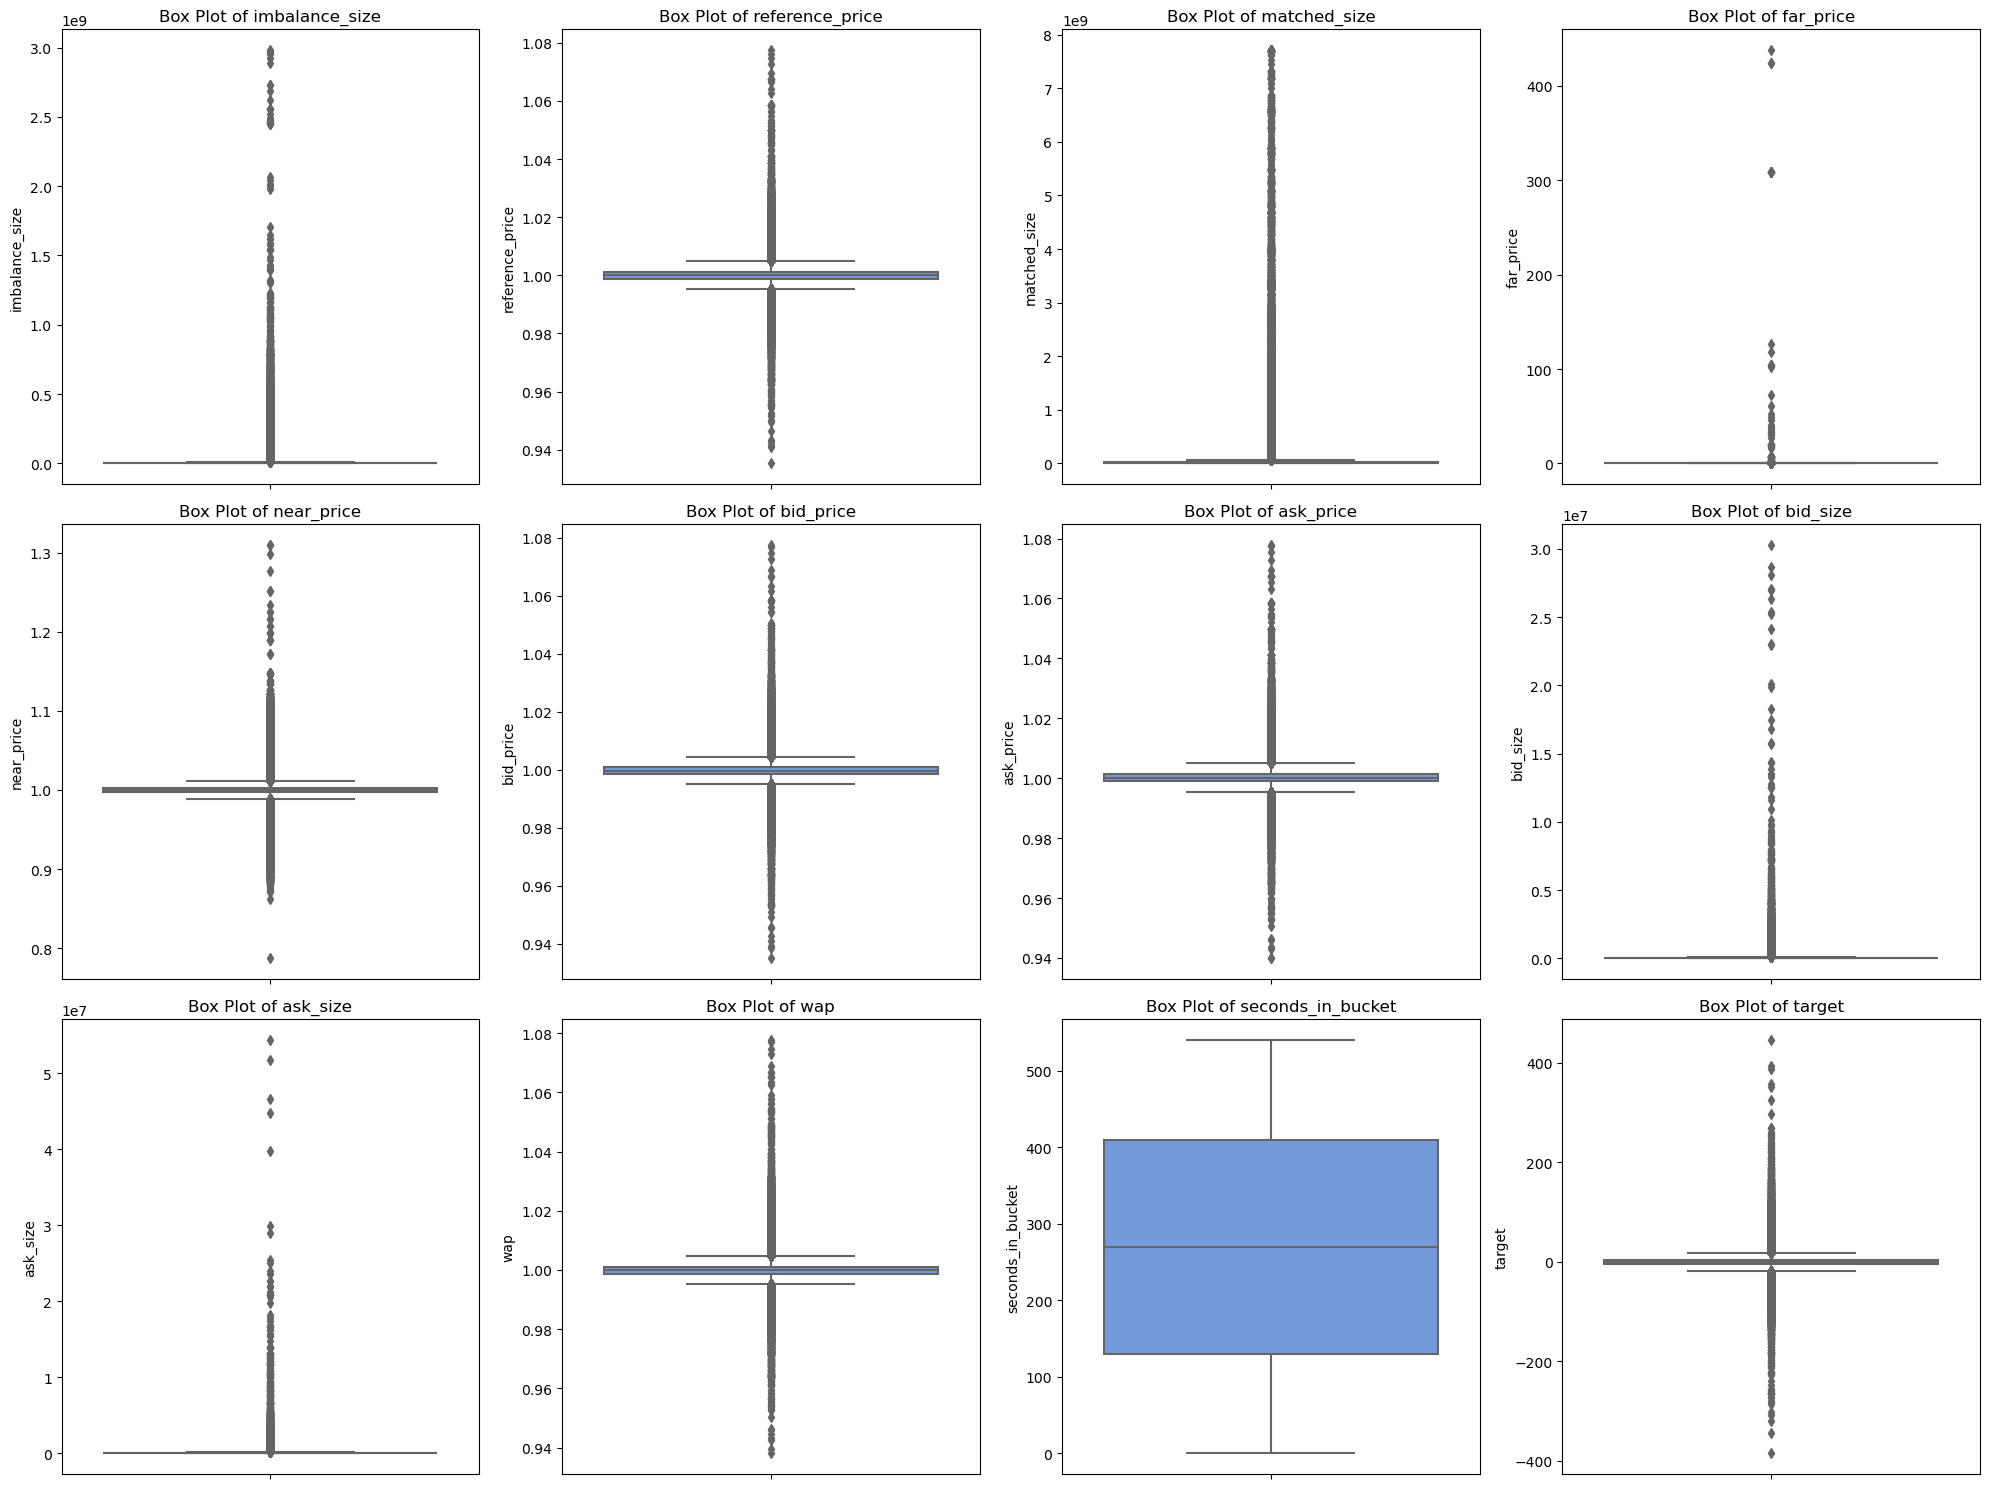

In [6]:
# Box Plots
n_cols = 4
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for i, var in enumerate(numerical_cols):
    sns.boxplot(data=df, y=var, color=COLOR, ax=axes[i])
    axes[i].set_title(f'Box Plot of {var}')
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

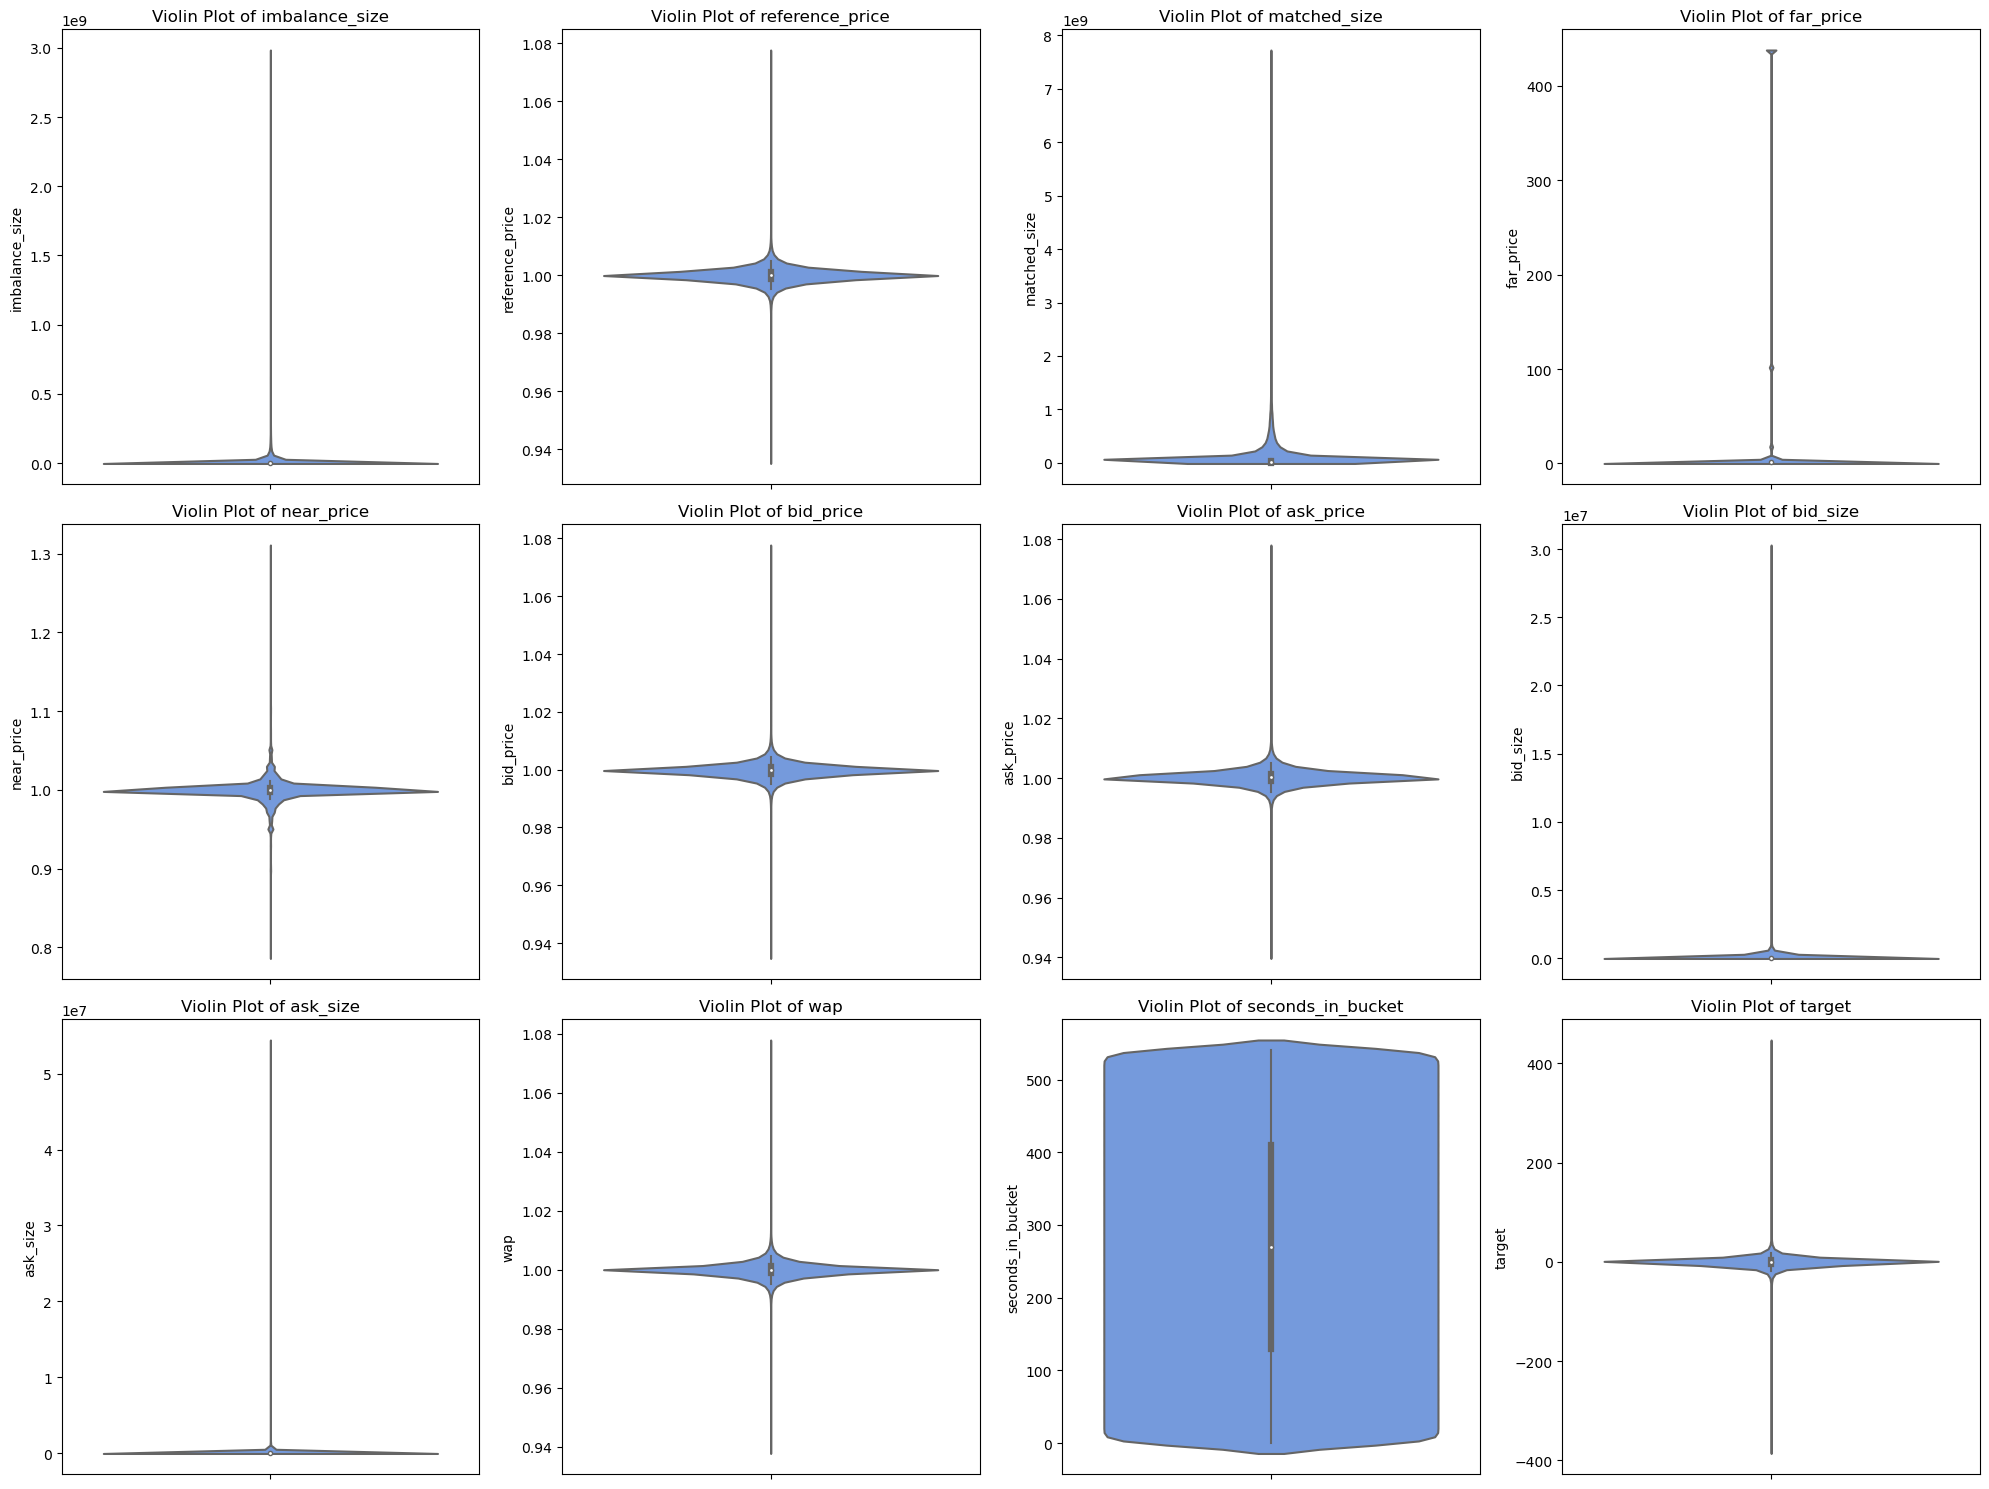

In [7]:
# Violin Plots
n_cols = 4
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for i, var in enumerate(numerical_cols):
    sns.violinplot(data=df, y=var, color=COLOR, ax=axes[i])
    axes[i].set_title(f'Violin Plot of {var}')
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

All columns, except for `seconds_in_bucket` have bad box and violin distribution plots.
That is a clear sign that we should consider cleaning our data. Lets apply some techniques to get rid of outliers and see the new distributions. But first display the distributions we have now

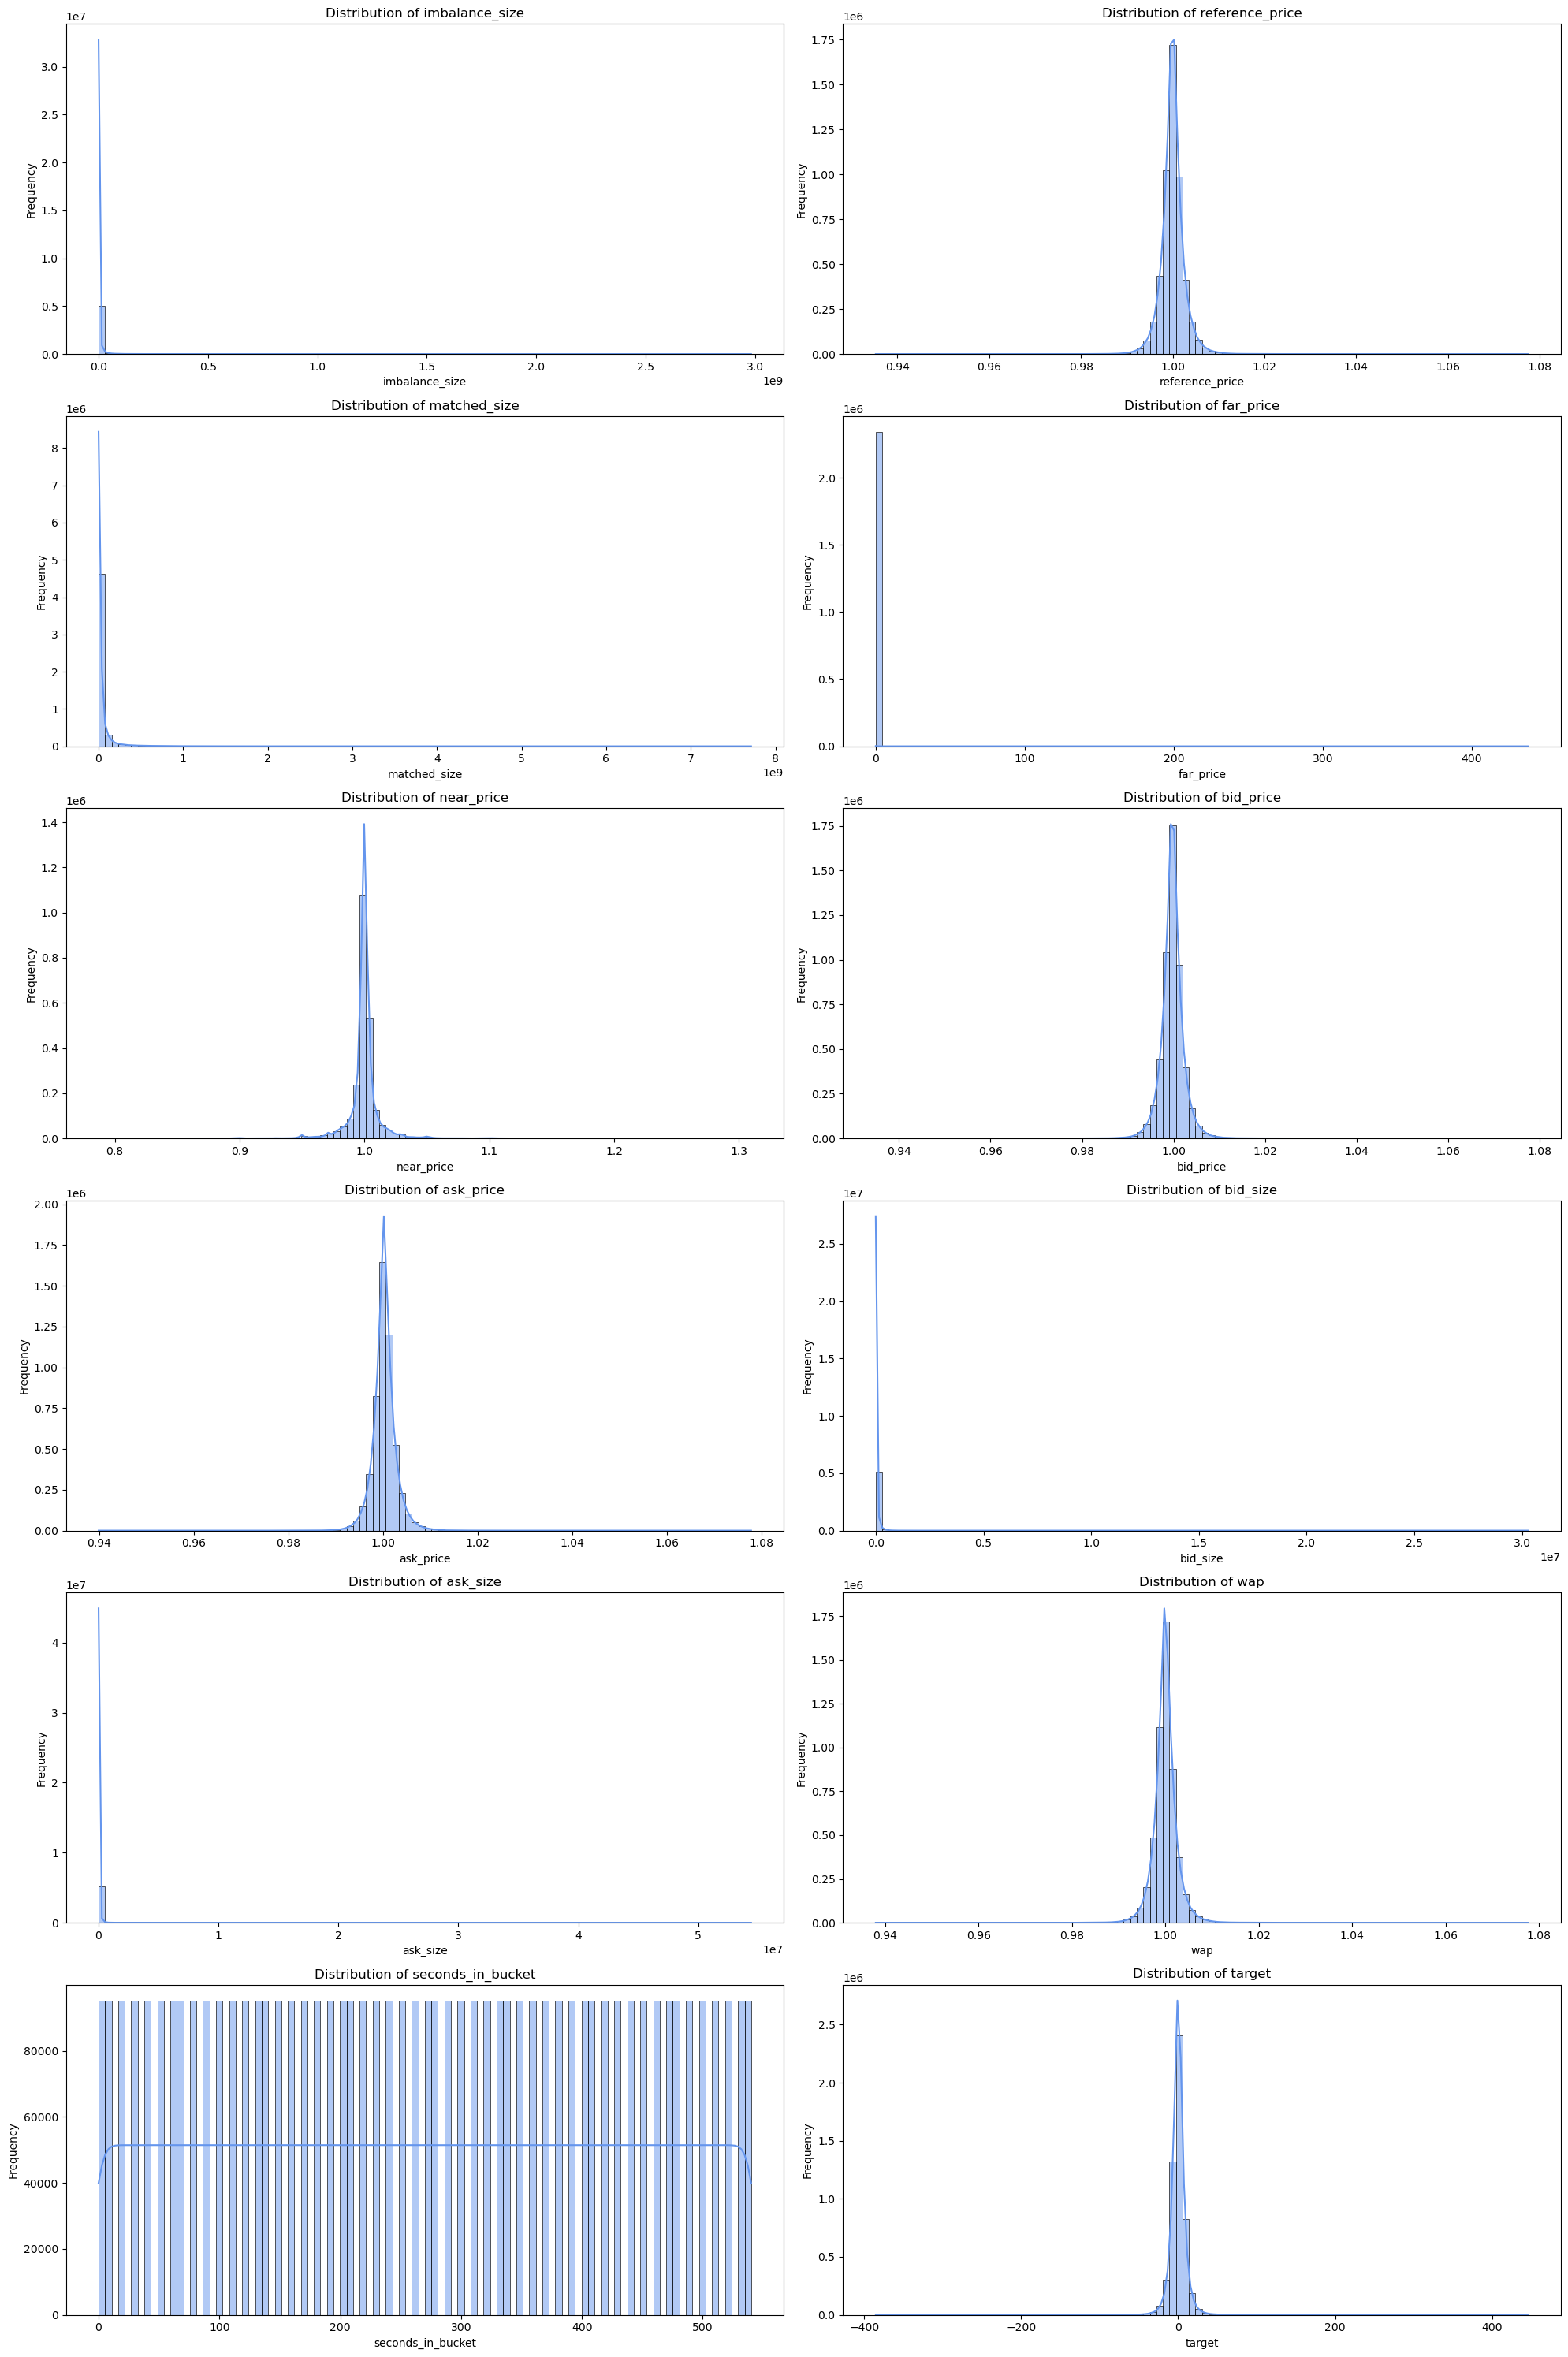

In [8]:
n_cols = 2
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for i, var in enumerate(numerical_cols):
    sns.histplot(df.sort_values(by=var, ascending=True)[var], bins=100, kde=True, color=COLOR, ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [9]:
# drop outliers using 3IQR method and plot new graphs
def three_iqr(df, columns, threshold):
    print('Method: 3IQR')
    outlier_counts = {}
    outlier_mask = pd.Series(data=False, index=df.index)
    initial_len = len(df)
    
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        column_outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
        outlier_mask = outlier_mask | column_outliers
        outlier_counts[column] = column_outliers.sum()
        print(f'Number of outliers in {column}: {outlier_counts[column]} ({round(outlier_counts[column] / initial_len, 2)}%)')
    
    new_df = df[~outlier_mask]
    print(f'Total number of outliers is {initial_len - len(new_df)}')
    print(f'Share of outliers is {1 - (len(new_df) / initial_len):.2f}')
        
    return new_df

In [10]:
new_df = three_iqr(df, numerical_cols, 1.5).reset_index(drop=True)

Method: 3IQR
Number of outliers in imbalance_size: 619374 (0.12%)
Number of outliers in reference_price: 320803 (0.06%)
Number of outliers in matched_size: 637237 (0.12%)
Number of outliers in far_price: 501784 (0.1%)
Number of outliers in near_price: 379172 (0.07%)
Number of outliers in bid_price: 324025 (0.06%)
Number of outliers in ask_price: 321691 (0.06%)
Number of outliers in bid_size: 509948 (0.1%)
Number of outliers in ask_size: 505021 (0.1%)
Number of outliers in wap: 325523 (0.06%)
Number of outliers in seconds_in_bucket: 0 (0.0%)
Number of outliers in target: 292263 (0.06%)
Total number of outliers is 2290075
Share of outliers is 0.44


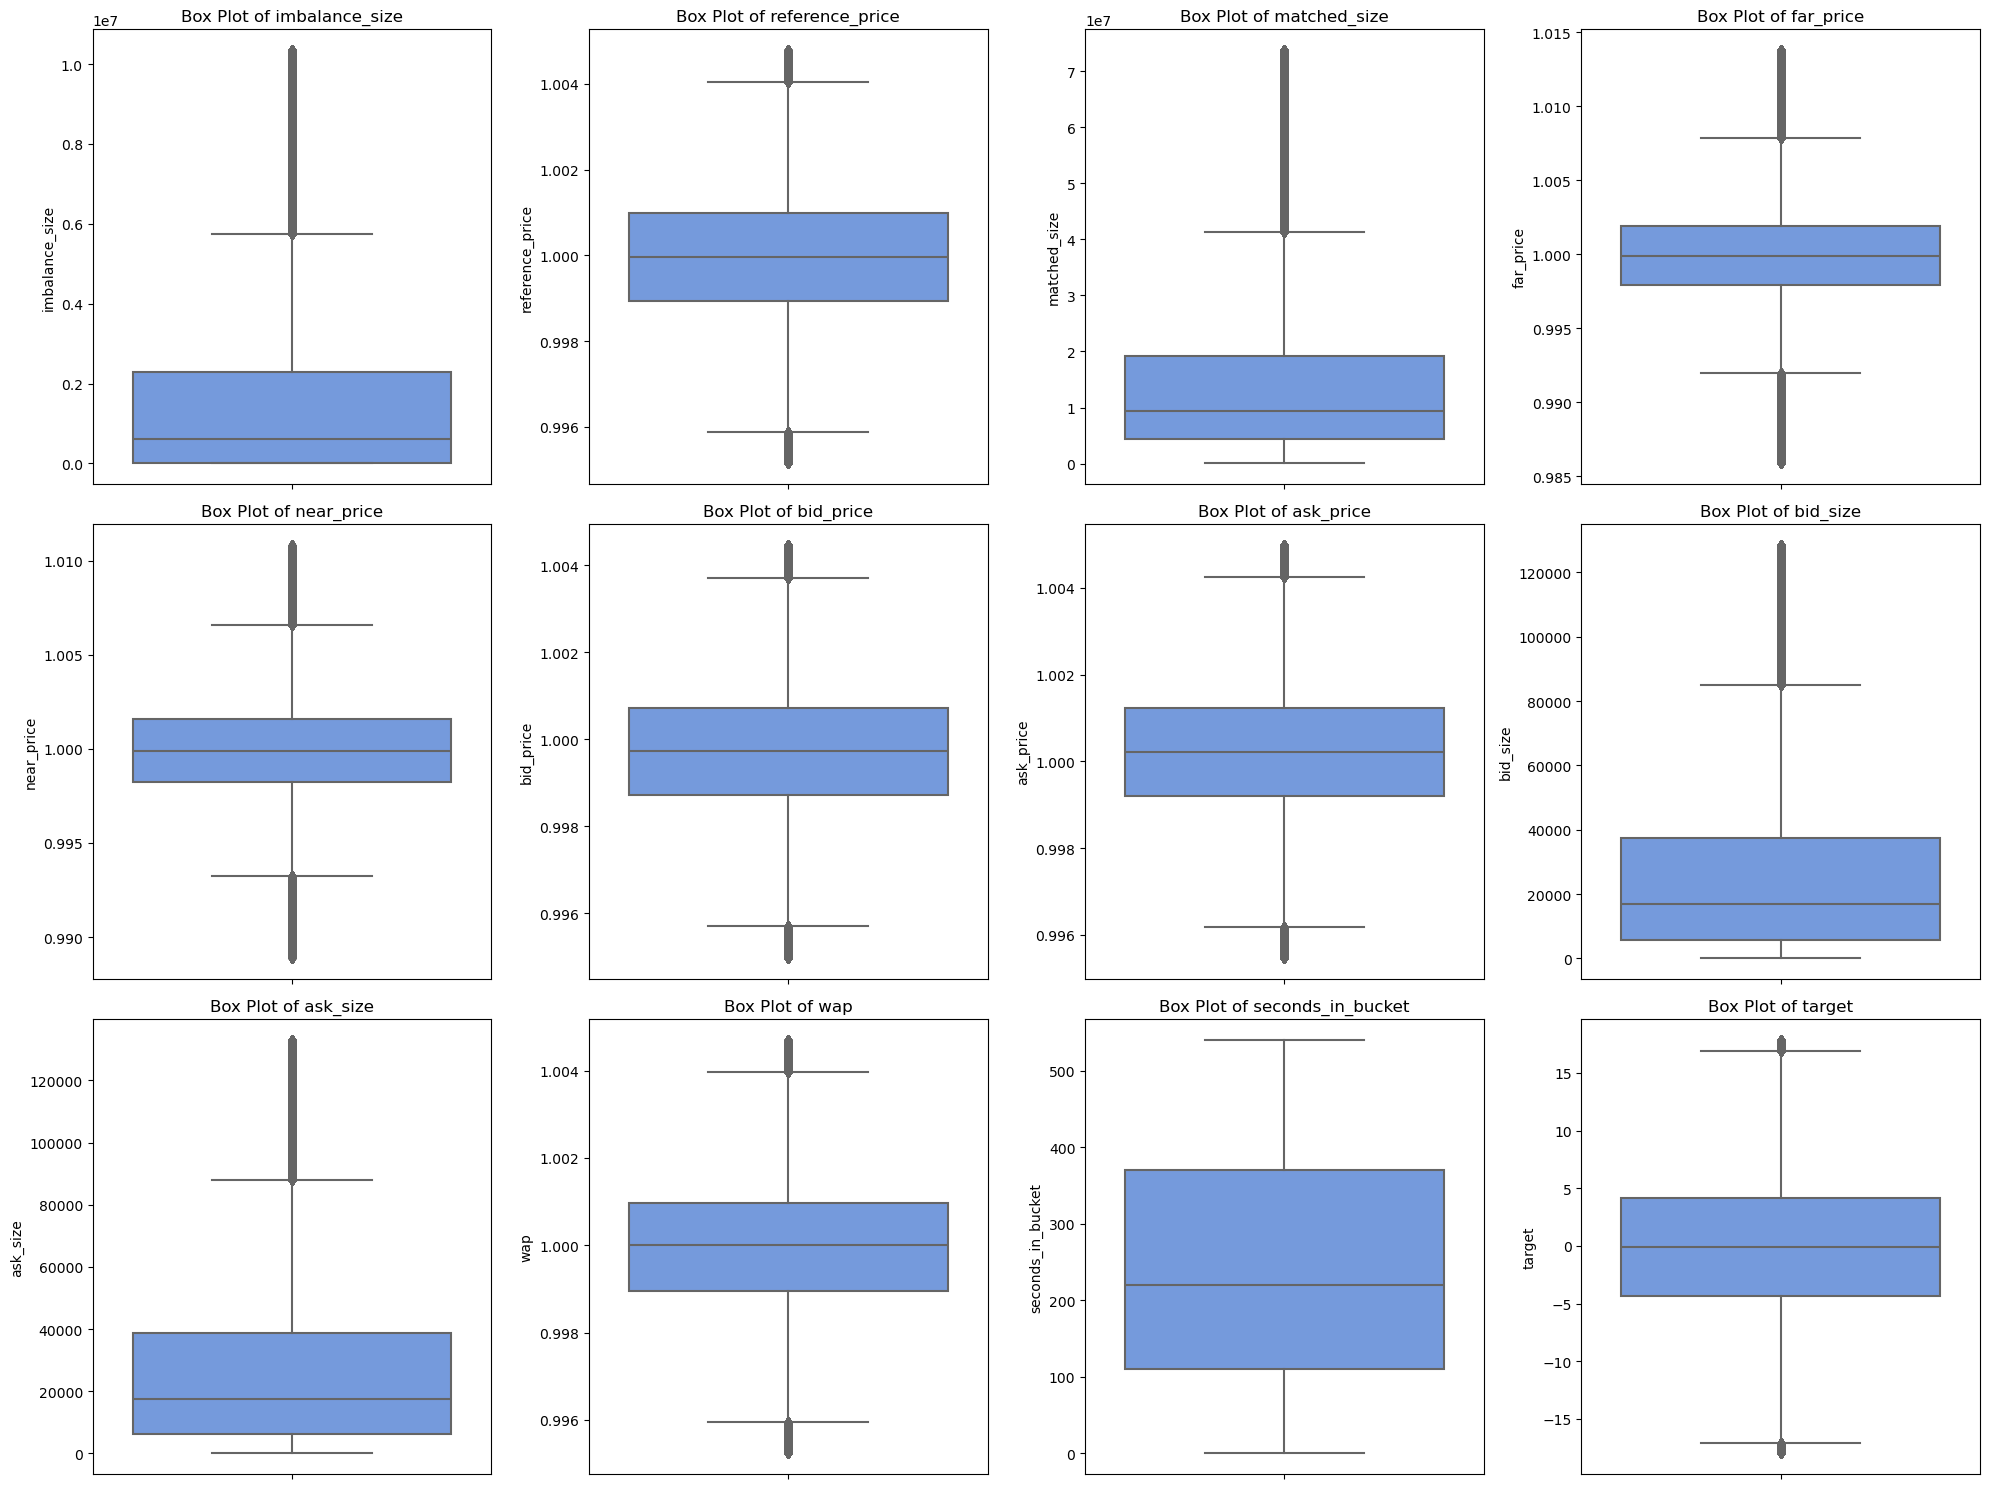

In [11]:
# Box Plots
n_cols = 4
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for i, var in enumerate(numerical_cols):
    sns.boxplot(data=new_df, y=var, color=COLOR, ax=axes[i])
    axes[i].set_title(f'Box Plot of {var}')
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

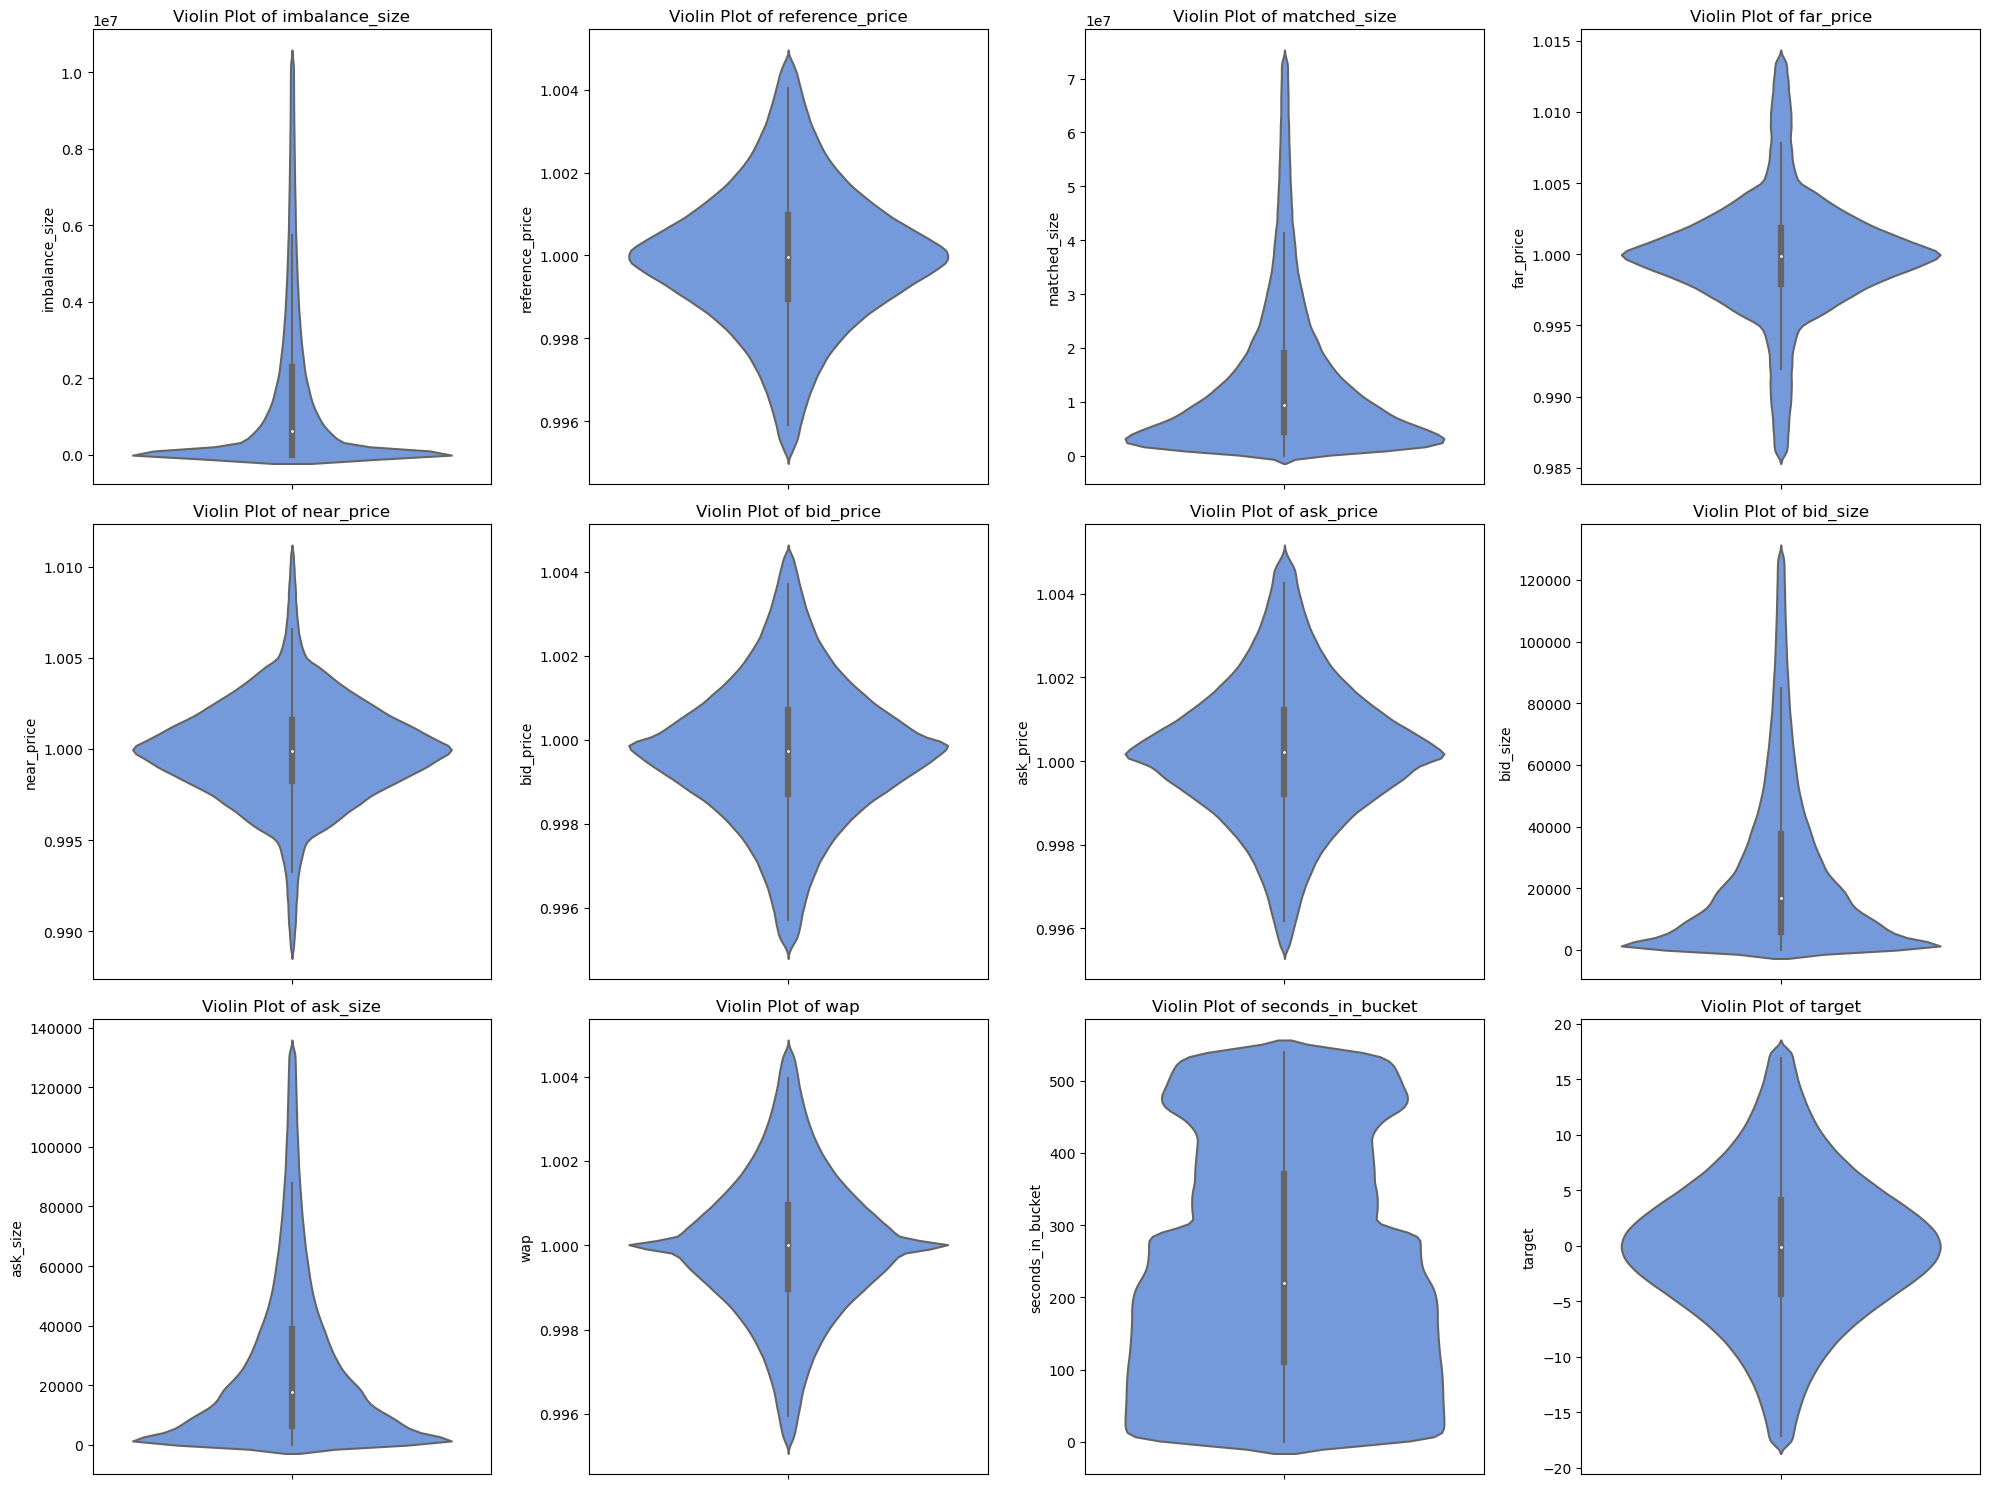

In [12]:
# Violin Plots
n_cols = 4
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for i, var in enumerate(numerical_cols):
    sns.violinplot(data=new_df, y=var, color=COLOR, ax=axes[i])
    axes[i].set_title(f'Violin Plot of {var}')
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

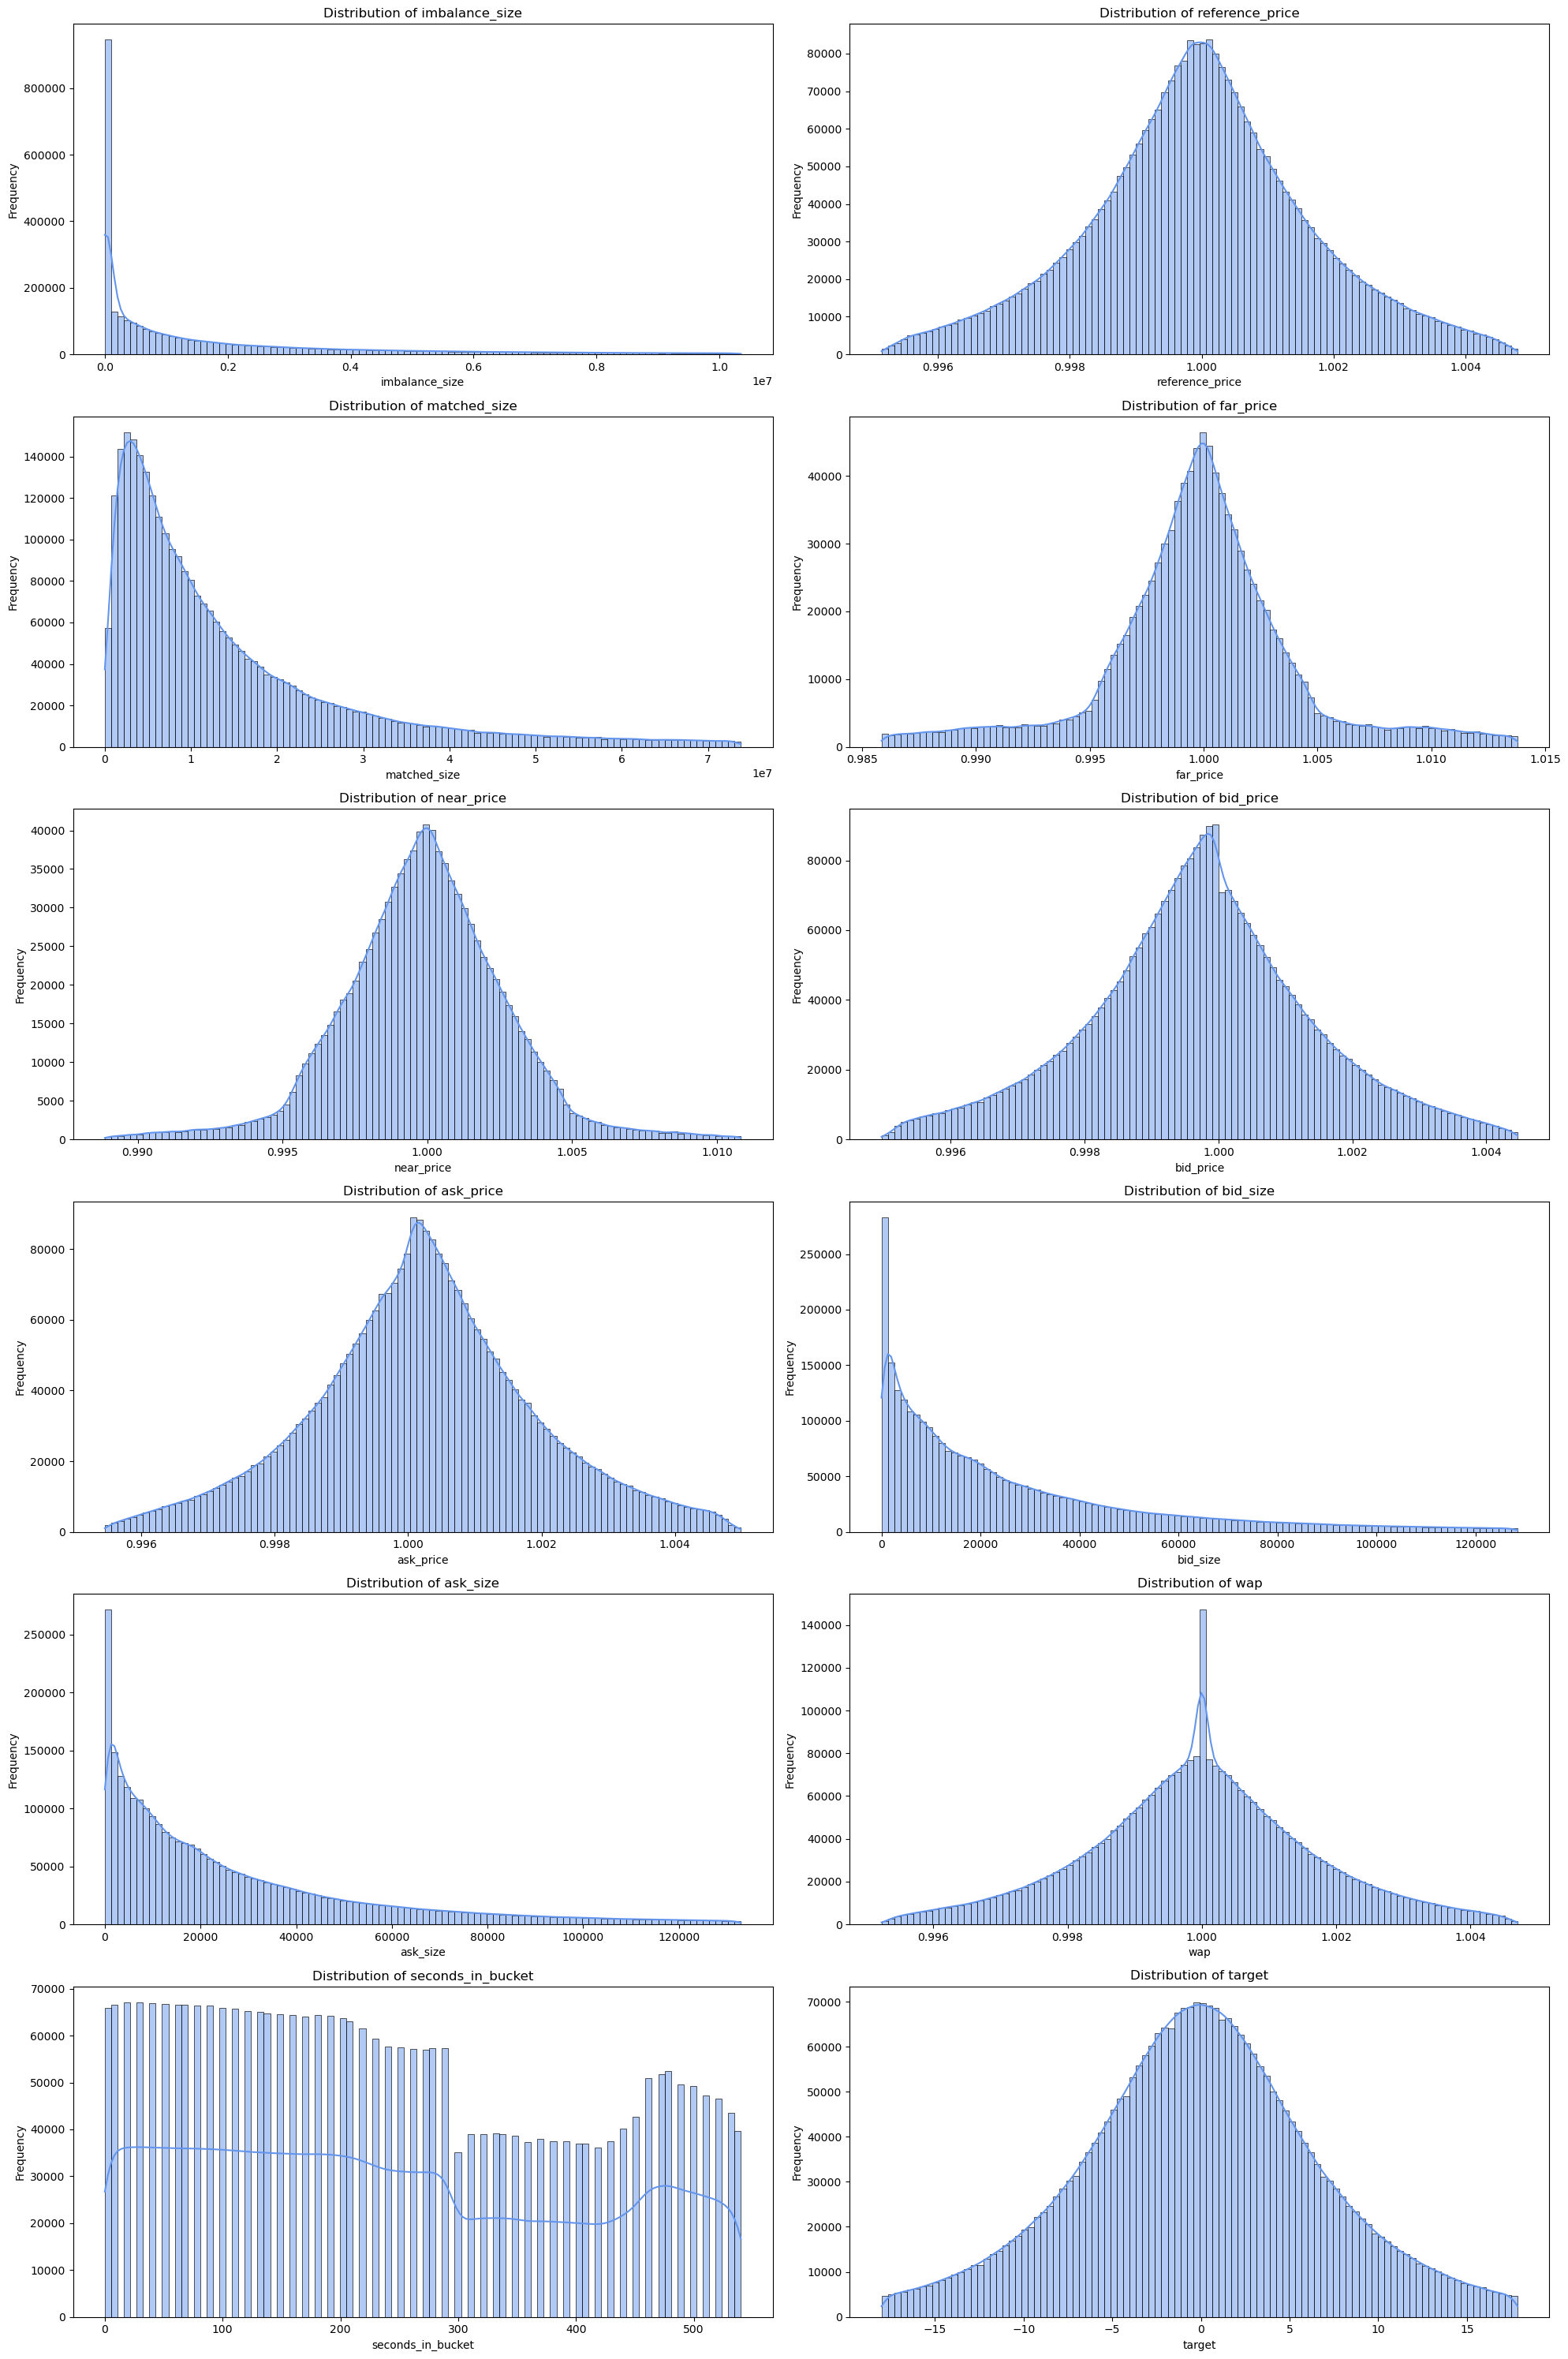

In [13]:
n_cols = 2
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for i, var in enumerate(numerical_cols):
    sns.histplot(new_df.sort_values(by=var, ascending=True)[var], bins=100, kde=True, color=COLOR, ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Baseline model creation

Let's create a baseline model for our data. We will use basic data handling techniques to understand, how our model perform on base data, without any 'hard' preprocessing made. This will help to understand, how efficient our future improvements are in terms of score

In [14]:
# Function to fill missing values 
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    # fill nans with mean values 
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

    stock_list = df['stock_id'].unique()
    for stock in stock_list:
        stock_df_indices = df['stock_id'] == stock

        for column in ['imbalance_size', 'reference_price', 'matched_size', 
                       'ask_price', 'wap', 'target', 'bid_price']:
            df.loc[stock_df_indices, column] = imp_mean.fit_transform(df.loc[stock_df_indices, [column]])
            
    return df

df_base = df.drop(['far_price', 'near_price'], axis=1)
df_base = preprocess_data(df_base)

In [15]:
# Split data to X,y, train, test
y = df_base['target']
X = df_base.drop(['target'], axis = 1)
X = X.drop(['time_id'], axis = 1)
# test = test.drop(['time_id'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 23)

In [16]:
# Check performances of different models on cross validation. Some models might be commented because they gave a worse score, so we do not need to run them, 
# but kept in order to show that they were used before

models = {
    "XGBRegressor": XGBRegressor(n_estimators=50),
    "CatBoostRegressor": CatBoostRegressor(n_estimators=50, verbose=False, random_seed=42),
    # "LGBMRegressor": LGBMRegressor(n_estimators=100, verbose=0, force_col_wise=True, device="gpu"),
    # "RandomForestRegressor": RandomForestRegressor(n_estimators=100),
    # "GradientBoostingRegressor": GradientBoostingRegressor(n_estimators=100),
    # "SVR": SVR(),
    "Ridge": Ridge(),
    # "ElasticNet": ElasticNet(),
    # "DecisionTreeRegressor": DecisionTreeRegressor(),
    "LinearRegression": LinearRegression(),
    "KNeighborsRegressor": KNeighborsRegressor()
    # "AdaBoostRegressor": AdaBoostRegressor(n_estimators=100),
    # "ExtraTreesRegressor": ExtraTreesRegressor(n_estimators=100)
}

baseline_scores = pd.DataFrame({'Model':[],
                                'Score':[]})

for model_name, model in models.items():
    print(f'fitting {model_name}')
    pipeline = make_pipeline(model)
    cv_score = -1 * np.mean(cross_val_score(pipeline, X, y, cv=3, scoring='neg_mean_absolute_error'))
    baseline_scores = pd.concat([baseline_scores, pd.DataFrame(data={'Model': [model_name], 'Score': [cv_score]})])

fitting XGBRegressor
fitting CatBoostRegressor
fitting Ridge
fitting LinearRegression
fitting KNeighborsRegressor


In [17]:
baseline_scores.sort_values(by='Score')

,Model,Score
0,LinearRegression,6.327844
0,CatBoostRegressor,6.372592
0,Ridge,6.385431
0,XGBRegressor,6.406202
0,KNeighborsRegressor,7.536551


In [18]:
test = test.drop(['far_price', 'near_price', 'currently_scored'], axis=1)

Our baseline score is **6.33**, the best model is `LinearRegression`. So, that is the score we will compare our future models with.

# Increasing model score
Now let's think about some ways we can possibly increase out model's performance. But first, we will define functions which will save us time in future

In [19]:
def get_scores(models, train, val):
    X_train, y_train = train.drop('target', axis=1), train['target']
    X_val, y_val = val.drop('target', axis=1), val['target']
    X_test, y_test = test, test_target.dropna()['revealed_target']
    
    for model_name, model in models.items():
        # m = model(**params)
        model.fit(X_train, y_train)
        pred_val = model.predict(X_val)
        pred_test = model.predict(X_test)
        
        mae_val = mean_absolute_error(y_val, pred_val)
        mae_test = mean_absolute_error(y_test, pred_test)
        
        print(model_name)
        print(f'Validation MAE: {mae_val:.2f}')
        print(f'Test MAE: {mae_test:.2f}\n')

## Without outliers

We will check the model performance without outliers. Despite the fact, that they cannot be considered outliers, maybe training on more balances data would increase the score

In [20]:
train, val = train_test_split(df_base, test_size=0.3, random_state=42)
train = three_iqr(train, train.select_dtypes(include=['int64', 'float64']).columns, 1.5)

Method: 3IQR
Number of outliers in stock_id: 0 (0.0%)
Number of outliers in date_id: 0 (0.0%)
Number of outliers in seconds_in_bucket: 0 (0.0%)
Number of outliers in imbalance_size: 433755 (0.12%)
Number of outliers in imbalance_buy_sell_flag: 0 (0.0%)
Number of outliers in reference_price: 224518 (0.06%)
Number of outliers in matched_size: 445908 (0.12%)
Number of outliers in bid_price: 226665 (0.06%)
Number of outliers in bid_size: 356646 (0.1%)
Number of outliers in ask_price: 225667 (0.06%)
Number of outliers in ask_size: 353253 (0.1%)
Number of outliers in wap: 227944 (0.06%)
Number of outliers in target: 204583 (0.06%)
Number of outliers in time_id: 0 (0.0%)
Total number of outliers is 1379295
Share of outliers is 0.38


In [21]:
models = {
    "CatBoostRegressor": CatBoostRegressor(n_estimators=50, verbose=False, random_seed=42),
    "LinearRegression": LinearRegression(fit_intercept=True)
}

get_scores(models=models, train=train, val=val)

CatBoostRegressor
Validation MAE: 6.32
Test MAE: 5.44

LinearRegression
Validation MAE: 6.34
Test MAE: 5.48



There is no difference in keeping or getting rid of outliers, both the scores are 6.32

## Scaling
Next, we will try to select features we need to scale and scale them with the respect to stock_id (IMO it is the best in terms of specifying the max params and making model simple. We cannot pay attention for both stock_id and time-relative features as we wont have them in test data)

In [15]:
def scale_data(df: pd.DataFrame, scaler_dict=None) -> (pd.DataFrame, dict):    
    # initialize dict to save scalers for future use on test dataset
    if scaler_dict is None:
        scaler_dict = {}

    stock_list = df['stock_id'].unique()
    
    for stock in stock_list:
        stock_indices = df[df['stock_id'] == stock].index
        
        if stock not in scaler_dict:
            scaler = StandardScaler()
            df.loc[stock_indices, ['matched_size', 'bid_size', 'ask_size']] = scaler.fit_transform(df.loc[stock_indices, ['matched_size', 'bid_size', 'ask_size']])
            scaler_dict[stock] = scaler
        else:
            scaler = scaler_dict[stock]
            df.loc[stock_indices, ['matched_size', 'bid_size', 'ask_size']] = scaler.transform(df.loc[stock_indices, ['matched_size', 'bid_size', 'ask_size']])

    return df, scaler_dict

df_scaled, scaler_dict = scale_data(df_base)

In [16]:
df_test_scaled, _ = scale_data(test, scaler_dict)

In [17]:
train, val = train_test_split(df_scaled, test_size=0.3, random_state=42)

models = {
    "CatBoostRegressor": CatBoostRegressor(n_estimators=50, verbose=False, random_seed=42),
    "LinearRegression": LinearRegression(fit_intercept=True)
}

X_train, y_train = train.drop('target', axis=1), train['target']
X_val, y_val = val.drop('target', axis=1), val['target']
X_test, y_test = test, test_target.dropna()['revealed_target']

for model_name, model in models.items():
    # m = model(**params)
    model.fit(X_train, y_train)
    pred_val = model.predict(X_val)
    pred_test = model.predict(X_test)
    
    mae_val = mean_absolute_error(y_val, pred_val)
    mae_test = mean_absolute_error(y_test, pred_test)
    
    print(model_name)
    print(f'Validation MAE: {mae_val:.2f}')
    print(f'Test MAE: {mae_test:.2f}\n')

CatBoostRegressor
Validation MAE: 6.32
Test MAE: 5.47

LinearRegression
Validation MAE: 6.33
Test MAE: 5.49



There is no meaningfull increase in score

## Better filling

We will redo filling by taking stock_id into account, so the stocks would be filled better. Also, we will use median, as it can act better on so noisy data

In [22]:
def fill_nans_with_median(df: pd.DataFrame, columns_to_fill, median_dict=None) -> (pd.DataFrame, dict):
    if median_dict is None:
        median_dict = {stock: {} for stock in df['stock_id'].unique()}
    
    for stock in df['stock_id'].unique():
        stock_rows = df['stock_id'] == stock
        for column in columns_to_fill:
            if column not in median_dict[stock]:
                median_dict[stock][column] = df.loc[stock_rows, column].median()
    
    for stock, medians in median_dict.items():
        stock_rows = df['stock_id'] == stock
        for column in columns_to_fill:
            df.loc[stock_rows, column] = df.loc[stock_rows, column].fillna(medians[column])
    
    return df, median_dict

columns_to_fill = ['imbalance_size', 'reference_price', 'matched_size', 'bid_price', 'wap']
df_filled, median_dict = fill_nans_with_median(df_base, columns_to_fill)

In [23]:
train, val = train_test_split(df_filled, test_size=0.3, random_state=42)

get_scores(models=models, train=train, val=val)

CatBoostRegressor
Validation MAE: 6.31
Test MAE: 5.50

LinearRegression
Validation MAE: 6.33
Test MAE: 5.49



Same results, mostly no increase

## Fill far_price and near_price
Now, let's analyze the importance of `far_price` and `near_price`, which we dropped in our initial model. 

Nasdaq provides an indication of the fair price called the reference price. The reference price is calculated as follows:
- If the near price is between the best bid and ask, then the reference price is equal to the near price
- If the near price > best ask, then reference price = best ask
- If the near price < best bid, then reference price = best bid So the reference price is the near price bounded between the best bid and ask.

Filling this features might help us to get more valuable features for the model

In [24]:
def near_price_filler(dataframe: pd.DataFrame) -> pd.DataFrame:
    data = dataframe.copy()
    data_for_fill = (data['seconds_in_bucket'] >= 300) & (data['near_price'].isna())
    
    
    # Replace missing 'near_price' values based on conditions
    mask_bid_eq_ref = (data['bid_price'] == data['reference_price']) & data_for_fill
    mask_for_equality = ((data['bid_price'] < data['reference_price']) \
                       & (data['reference_price'] < data['ask_price'])) & data_for_fill
    mask_ask_eq_ref = (data['ask_price'] == data['reference_price']) & data_for_fill
    
    data.loc[mask_bid_eq_ref, 'near_price'] = data.loc[mask_bid_eq_ref, 'reference_price']\
                                                    - np.std(df['reference_price'])
    data.loc[mask_for_equality, 'near_price'] = data.loc[mask_for_equality, 'reference_price']
    data.loc[mask_ask_eq_ref, 'near_price'] = data.loc[mask_ask_eq_ref, 'reference_price']\
                                                    + np.std(df['reference_price'])
    
    return data

In [25]:
def far_price_filler(dataframe: pd.DataFrame) -> pd.DataFrame:
    data = dataframe.copy()
    data_for_fill = (data['seconds_in_bucket'] >= 300) & (data['far_price'].isna())
    
    # Replace missing 'near_price' values based on conditions
    data.loc[data_for_fill, 'far_price'] = data.loc[data_for_fill, 'near_price']
        
    return data


In [26]:
def improved_preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # df.set_index("row_id", inplace=True)
    # df.drop(['far_price', 'near_price'], axis=1, inplace=True)

    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

    stock_list = df['stock_id'].unique()
    for stock in stock_list:
        stock_df_indices = df['stock_id'] == stock

        for column in ['imbalance_size', 'reference_price', 'matched_size', 
                       'ask_price', 'wap', 'target', 'bid_price', 'far_price']:
            if column in df.columns:
                df.loc[stock_df_indices, column] = imp_mean.fit_transform(df.loc[stock_df_indices, [column]])
    
    df['price_presence_flg'] = (df['seconds_in_bucket'] >= 300).astype(int)
    df['near_price'][df['seconds_in_bucket']<300] = int(0)
    df['far_price'][df['seconds_in_bucket']<300] = int(10)
            
    df = near_price_filler(df)

    return df

In [29]:
df_new = improved_preprocess_data(df)
df_new = df_new.drop(['time_id'], axis=1)
# Again read test, to receive clear csv file
test = pd.read_csv('Optiver Trading Close/example_test_files/test.csv')
test = test.set_index('row_id')
test = test.drop(['time_id', 'currently_scored'], axis=1)
test = improved_preprocess_data(test)
train, val = train_test_split(df_new, test_size=0.3, random_state=42)

get_scores(models=models, train=train, val=val)

CatBoostRegressor
Validation MAE: 6.31
Test MAE: 5.49

LinearRegression
Validation MAE: 6.32
Test MAE: 5.49



Same again, results are a bit better, but increase is very low

## Stacking

We will try stacking some models, maybe this technique will use best parts of every model in time and we would get better results overall

In [30]:
lr = LinearRegression(fit_intercept=True)
cb = CatBoostRegressor(n_estimators=50, verbose=False, random_seed=42)
knn = KNeighborsRegressor(n_neighbors=25)

stack1 = StackingRegressor(
    estimators=[
        ('lr', lr),
        ('cb', cb)
    ],
    final_estimator=LinearRegression()
)

stack2 = StackingRegressor(
    estimators=[
        ('knn', knn),
        ('cb', cb)
    ],
    final_estimator=LinearRegression()
)

stack3 = StackingRegressor(
    estimators=[
        ('knn', knn),
        ('cb', cb),
        ('lr', lr)
    ],
    final_estimator=LinearRegression()
)

models_stacking = {
    "CB + LR": stack1,
    "CB + KNN": stack2,
    "CB + KNN + LR": stack3
}

get_scores(models=models_stacking, train=train, val=val)

CB + LR
Validation MAE: 6.31
Test MAE: 5.51

CB + KNN
Validation MAE: 6.28
Test MAE: 5.57

CB + KNN + LR
Validation MAE: 6.28
Test MAE: 5.57



On validation set we improved our results. However, this work bad on test dataset

## Split by 5 minutes

We can try to split data on before 5 minutes and after 5 and create 2 models. The reason for this is that NASDAQ starts accepting MOC order in 3:55 pm, so we get info about far_price and near_price, so the structure of auctions changes

In [31]:
def df_to_training(df):
    df = df.copy()
    df1 = df[df['seconds_in_bucket']<300]
    df2 = df[df['seconds_in_bucket']>=300]

    y1 = df1['target']
    X1 = df1.drop(['target'], axis = 1)
    # X1 = X1.drop(['time_id'], axis = 1)

    y2 = df2['target']
    X2 = df2.drop(['target'], axis = 1)
    # X2 = X2.drop(['time_id'], axis = 1)

    return X1, y1, X2, y2

X1, y1, X2, y2 = df_to_training(df_new)

In [32]:
def get_scores_5min(models, train):
    X1, y1, X2, y2 = df_to_training(train)

    test = pd.read_csv('Optiver Trading Close/example_test_files/test.csv')
    test = improved_preprocess_data(test)
    test = test.drop(['currently_scored', 'time_id'], axis=1)
    test1 = test[test['seconds_in_bucket']<300].index
    test2 = test[test['seconds_in_bucket']>=300].index

    Xt1 = test.loc[test1].set_index('row_id')
    Xt2 = test.loc[test2].set_index('row_id')
    yt = test_target['revealed_target'].dropna().reset_index()
    yt1 = yt['revealed_target'].loc[test1]
    yt2 = yt['revealed_target'].loc[test2]
    
    for model_name, model in models.items():
        if model_name == 'LinearRegression':
            model1 = LinearRegression()
            model2 = LinearRegression()
        else:
            model1 = model.copy()
            model2 = model.copy()

        model1.fit(X1, y1)
        model2.fit(X2, y2)
        pred_val1 = model1.predict(X1)
        pred_val2 = model1.predict(X2)
        pred_val = np.concatenate([pred_val1, pred_val2])
        pred_test1 = model1.predict(Xt1)
        pred_test2 = model2.predict(Xt2)
        pred_test = np.concatenate([pred_test1, pred_test2])
        
        mae_val = mean_absolute_error(np.concatenate([y1, y2]), pred_val)
        mae_test = mean_absolute_error(np.concatenate([yt1, yt2]), pred_test)
        
        print(model_name)
        print(f'Validation MAE: {mae_val:.2f}')
        print(f'Test MAE: {mae_test:.2f}\n')

In [33]:
get_scores_5min(models, df_new)

CatBoostRegressor
Validation MAE: 6.36
Test MAE: 5.50

LinearRegression
Validation MAE: 6.32
Test MAE: 5.50



As a result, on test we have better results, but on train we have worse

## Targeting best test result

As the best model for targeting test dataset (i.e. kaggle score), we took default catboost model. It has MAE of 5.39, which is the best result we got, so we can draw a conclusion that simple model works best. The baseline for silver medals is 5.33, so we were close, however did not manage to send final predictions before the competition closed.

In [34]:
models = {
    "CatBoostRegressor": CatBoostRegressor(n_estimators=50, verbose=False, random_seed=42, learning_rate = 0.001),
    "LinearRegression": LinearRegression(fit_intercept=True)
}

get_scores(models=models, train=train, val=val)

CatBoostRegressor
Validation MAE: 6.41
Test MAE: 5.39

LinearRegression
Validation MAE: 6.32
Test MAE: 5.49

